# Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import re

# for data cleaning
import string

# for calculating Polarity and Subjectivity
from textblob import TextBlob

# import all the necessary libraries
import warnings

#for Tokenization
import nltk

#for Wordscloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize

#Ignoring unnecessory warnings
warnings.filterwarnings("ignore")                   

# for stopwords Removal
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# for removing accented and special chracters
import plotly.express as px
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier              #for data manipulation and analysis 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score , f1_score , classification_report , roc_curve , auc , roc_auc_score , zero_one_loss
from sklearn.linear_model import LinearRegression

# Importing and Reading

In [2]:
paths = [ '../input/commonlitreadabilityprize/sample_submission.csv' ,
          '../input/commonlitreadabilityprize/test.csv' , 
          '../input/commonlitreadabilityprize/train.csv'
          ]

train = pd.read_csv(paths[2])
test = pd.read_csv(paths[1])
submission = pd.read_csv(paths[0])

display( train.head() )

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [3]:
display( train.isnull().sum() )

id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64

In [4]:
train.drop(['url_legal' , 'license'] , axis=1 , inplace = True)

display( train.head() )

,id,excerpt,target,standard_error
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [5]:
train['excerpt'][0]

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

# Preprocessing

In [6]:
stop_words = nltk.corpus.stopwords.words("english")

def preprocess(text):
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    text = text.str.replace(regex_pat, ' ')
    
    # removal of punctuations and numbers
    punc_remove = text.str.replace("[^a-zA-Z]", " ")
    
    # remove whitespace with a single space
    new_text=punc_remove.str.replace(r'\s+', ' ')
    
    # remove leading and trailing whitespace
    new_text=new_text.str.replace(r'^\s+|\s+?$','')
    
    # replace normal numbers with numbr
    new_text=new_text.str.replace(r'\d+(\.\d+)?','numbr')
    
    # removal of capitalization
    text_lower = new_text.str.lower()
    
    # tokenizing
    tokenized_text = text_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_text=  tokenized_text.apply(lambda x: [item for item in x if item not in stop_words])
    
    for i in range(len(tokenized_text)):
        tokenized_text[i] = ' '.join(tokenized_text[i])
        texts_p= tokenized_text
    
    return texts_p
    

In [7]:
#train['excerpt'] = train['excerpt'].apply(preprocess)
text = train.excerpt
preprocessed_text = preprocess(text)

train['preprocessed_excerpt'] = preprocessed_text

print(train['excerpt'][0])
print('')
print(train['preprocessed_excerpt'][0])


When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowshoes.

young 

# Feature Engineering

Check for more fe (comparison on nouns , adj etc)

In [8]:
train.describe()

,target,standard_error
count,2834.000000,2834.000000
mean,-0.959319,0.491435
std,1.033579,0.034818
min,-3.676268,0.000000
25%,-1.690320,0.468543
50%,-0.912190,0.484721
75%,-0.202540,0.506268
max,1.711390,0.649671


In [9]:
train['length'] = train['preprocessed_excerpt'].apply(len)

train.head()

,id,excerpt,target,standard_error,preprocessed_excerpt,length
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,young people returned ballroom presented decid...,606
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time mrs fayre somewhat silent eyes res...,555
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,roger predicted snow departed quickly came two...,529
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,outside palace great garden walled round fille...,588
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,upon time three bears lived together house woo...,414


**Text Polarity**

It is the expression that determines the sentimental aspect of an opinion. In textual data, the result of sentiment analysis can be determined for each entity in the sentence, document or sentence. The sentiment polarity can be determined as positive, negative and neutral.

In [10]:
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

train['polarity'] = train['preprocessed_excerpt'].apply(get_polarity)
train.head()

,id,excerpt,target,standard_error,preprocessed_excerpt,length,polarity
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,young people returned ballroom presented decid...,606,0.173333
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time mrs fayre somewhat silent eyes res...,555,0.093770
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,roger predicted snow departed quickly came two...,529,0.011064
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,outside palace great garden walled round fille...,588,0.351441
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,upon time three bears lived together house woo...,414,0.168534


**Text Subjectivity**

In natural language, subjectivity refers to expression of opinions, evaluations, feelings, and speculations and thus incorporates sentiment. Subjective text is further classified with sentiment or polarity.

In [11]:
# Lets calculate the Subjectvity of the Reviews
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
train['subjectivity'] = train['preprocessed_excerpt'].apply(get_subjectivity)
train.head()

,id,excerpt,target,standard_error,preprocessed_excerpt,length,polarity,subjectivity
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,young people returned ballroom presented decid...,606,0.173333,0.503333
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,dinner time mrs fayre somewhat silent eyes res...,555,0.093770,0.548862
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,roger predicted snow departed quickly came two...,529,0.011064,0.506443
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,outside palace great garden walled round fille...,588,0.351441,0.643860
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,upon time three bears lived together house woo...,414,0.168534,0.481034


In [12]:
train[['length','polarity','subjectivity']].describe().style.background_gradient(cmap = 'copper')

,length,polarity,subjectivity
count,2834.000000,2834.000000,2834.000000
mean,609.168313,0.099746,0.464646
std,114.780391,0.121969,0.114601
min,301.000000,-0.550000,0.058333
25%,526.000000,0.022957,0.390956
50%,599.000000,0.093750,0.464940
75%,685.000000,0.173333,0.541667
max,1050.000000,0.630000,0.905000


# Training (Feature Extraction)

**Bag of Words VS TFIDF**

**1) Bag of Words**

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

In [13]:
# Creating bag of words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=30000)

X = cv.fit_transform(train['preprocessed_excerpt']).toarray()
y = train.target

In [14]:
# Feature Scaling
sc = StandardScaler()
X = sc.fit_transform(X)

In [15]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

print(X_train.shape , X_test.shape)

(2125, 26065) (709, 26065)


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb

In [17]:
dic_models = {#'RandomForestRegressor' : RandomForestRegressor(criterion='mse'), 
              #'GradientBoosting' : GradientBoostingRegressor() ,
              'LightGBM' : lgb.LGBMRegressor(),
              'XGradientBoosting' : xgb.XGBRegressor()    
                }
            #'CBR' : cb.CatBoostRegressor() 
    
for i in dic_models:
    print('Training with ' + i + ' model. \n')
    
    model = dic_models[i].fit(X_train , y_train)
    
    #Predicting
    print('Predicting with ' + i + ' model. \n')
    pred = model.predict(X_test)
    
    # Using Accuracy Score for predicting models
    print("Accuracy of " + i + " Model is ", model.score(X_test , y_test))
    print("RMSE of " + i + " Model is ", np.sqrt(mean_squared_error(y_test , pred)))    
    print("------------------------------------------------------------------")
    print()    

Training with LightGBM model. 

Predicting with LightGBM model. 

Accuracy of LightGBM Model is  0.40265439801455005
RMSE of LightGBM Model is  0.80299497554423
------------------------------------------------------------------

Training with XGradientBoosting model. 

Predicting with XGradientBoosting model. 

Accuracy of XGradientBoosting Model is  0.36473142994408625
RMSE of XGradientBoosting Model is  0.8280921679983115
------------------------------------------------------------------



In [18]:
#Fitting Linear Regression to the data set
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

#Calculating Details
print('LogisticRegressionModel Train Score is : ' , lin_reg .score(X_train, y_train))
print('LogisticRegressionModel Test Score is : ' , lin_reg .score(X_test, y_test))

LogisticRegressionModel Train Score is :  1.0
LogisticRegressionModel Test Score is :  0.3933800471233381


rsquare no acc

**2) TFIDF**

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(train['preprocessed_excerpt'] )

In [20]:
matrix = pd.DataFrame(tfidf.toarray())
matrix

,0,1,2,3,4,5,6,7,8,9,...,26055,26056,26057,26058,26059,26060,26061,26062,26063,26064
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# If you don't specify the random_state in the code, 
# then every time you run(execute) your code a new random value is generated 
# and the train and test datasets would have different values each time.
X = tfidf
y = train.target
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.25)

print("Training split input- ", X_train_tfidf.shape)   # X FOR INPUT
print("Testing split input- ", X_test_tfidf.shape)

print("\n\nY : Training split input- ", y_train.shape) # Y FOR TARGET.
print("Y : Testing split input- ", y_test.shape)


Training split input-  (2125, 26065)
Testing split input-  (709, 26065)


Y : Training split input-  (2125,)
Y : Testing split input-  (709,)


In [22]:
models_2 = {#'RandomForestRegressor' : RandomForestRegressor(), 
              'GradientBoosting' : GradientBoostingRegressor() ,    
              'LightGBM' : lgb.LGBMRegressor(),
              'XGradientBoosting' : xgb.XGBRegressor()        
            }

for i in models_2:
    print('Training with ' + i + ' model. \n')
    
    model = models_2[i].fit(X_train_tfidf , y_train)
    
    #Predicting
    print('Predicting with ' + i + ' model. \n')
    pred = model.predict(X_test_tfidf)
    
    # Using Accuracy Score for predicting models
    print("R2 score of " + i + " Model is ", model.score(X_test_tfidf , y_test))
    print("RMSE of " + i + " Model is ", np.sqrt(mean_squared_error(y_test , pred)))    
    print("------------------------------------------------------------------")
    print()    

Training with GradientBoosting model. 

Predicting with GradientBoosting model. 

R2 score of GradientBoosting Model is  0.30752249459945813
RMSE of GradientBoosting Model is  0.8520290400530764
------------------------------------------------------------------

Training with LightGBM model. 

Predicting with LightGBM model. 

R2 score of LightGBM Model is  0.3949235239999126
RMSE of LightGBM Model is  0.7964466622644065
------------------------------------------------------------------

Training with XGradientBoosting model. 

Predicting with XGradientBoosting model. 

R2 score of XGradientBoosting Model is  0.28500866158262694
RMSE of XGradientBoosting Model is  0.8657688429212599
------------------------------------------------------------------



In [23]:
#Fitting Linear Regression to the data set
lin_reg = LinearRegression()
lin_reg.fit(X_train_tfidf,y_train)

pred = lin_reg.predict(X_test_tfidf)

#Calculating Details
print('LogisticRegressionModel Train Score is : ' , lin_reg .score(X_train_tfidf, y_train))
print('LogisticRegressionModel Test Score is : ' , lin_reg .score(X_test_tfidf, y_test))
print("RMSE of LOGREGModel is ", np.sqrt(mean_squared_error(y_test , pred)))

LogisticRegressionModel Train Score is :  0.9998901927149694
LogisticRegressionModel Test Score is :  0.45184872247311236
RMSE of LOGREGModel is  0.7580568516491895


# Data Visualization

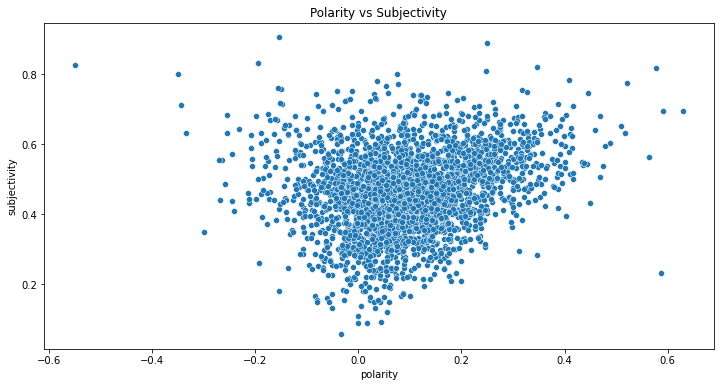

In [24]:
# lets check relation between Polarity and Subjectivity

plt.figure(figsize=(12,6))
sns.scatterplot(train['polarity'], train['subjectivity'])
plt.title('Polarity vs Subjectivity')
plt.show()

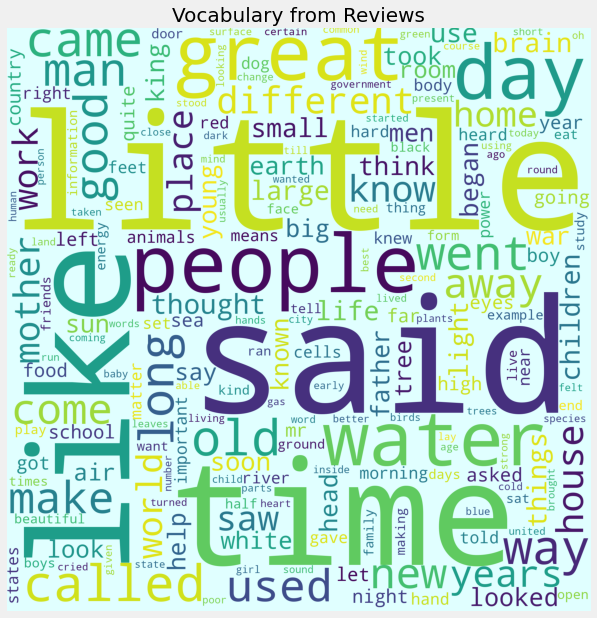

In [25]:
# lets plot the Wordscloud

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train['preprocessed_excerpt'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()

# Testing and Submission

In [26]:
#Training linear regression on complete Data

#Fitting Linear Regression to the data set
lin_reg = LinearRegression()
lin_reg.fit(X ,y)


LinearRegression()

In [27]:
X

<2834x26065 sparse matrix of type '<class 'numpy.float64'>'
	with 199882 stored elements in Compressed Sparse Row format>

In [28]:
test.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


**Preprocessing test data**

In [29]:
#train['excerpt'] = train['excerpt'].apply(preprocess)
text = test.excerpt
preprocessed_text = preprocess(text)

test['preprocessed_excerpt'] = preprocessed_text

print(test['excerpt'][0])
print('')
print(test['preprocessed_excerpt'][0])


My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted.
"I am certain to go wrong," I said to myself.
"It is out of my power to follow a direct course without something to serve as a compass. I will go back to the village and wait till morning."

hope lay jack promise would keep bright light burning upper story guide course clear night light visible village somehow failed take account state weather air full eddying flakes would render headlight locomotive invisible hun

In [30]:
import collections
import copy

corpus_vocabulary = collections.defaultdict(None, copy.deepcopy(tfidf_vectorizer.vocabulary_))
tfidf_transformer_query_sec = TfidfVectorizer(vocabulary=corpus_vocabulary)
query_tfidf_matrix = tfidf_transformer_query_sec.fit_transform(test['preprocessed_excerpt'])

# # TF-IDF feature matrix
# tfidf = tfidf_vectorizer.transform(test['preprocessed_excerpt'] )

In [31]:
pred = lin_reg.predict(query_tfidf_matrix)

In [32]:
pred[:5]

array([-1.88205366, -0.31933921, -0.12792198, -1.7975096 , -1.39483091])

In [33]:
submission.target = pred
submission.to_csv("submission.csv", index=False)